<a href="https://colab.research.google.com/github/sumants-dev/CIS545-Project/blob/main/Seasonal_weather_data__analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 - Weather Big Data Analysis

# 0 Introduction

* Team members:  Ashley Chang, Dana Yang, Sumant Shringari

**Our thesis: **

> Predict weather with different indicators of air pollution



**Our approach**

For this set of data we experimented with three different models to evulate the best result. 
1.  Regression SVM 
2.  PCA 
4.  Regressor Random forest 
5.  Times series with Sarima 

**Our data set consist of:** 

  Air pollution at city level 

    * Date range: 2020 - 2021
    * Final data set is 
  Air pollution By Country

    * Date range: 2010 - 2017
    * Final dataset is 1352 records



**Overview of results **


> Indented block



#1 Data setup

### 1.0 Importing data and library

In [1]:
!pip install pandasql
!pip install pandas
!pip install requests
!pip install lxml
!pip install nltk
!pip install pandasql

In [2]:
# Imports
import pandas as pd
import pandasql as psql
from lxml import html
import requests
import nltk


In [3]:
!pip install matplotlib
!pip install seaborn

In [4]:
import numpy as np 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
from datetime import timedelta
import glob
import seaborn as sns
import re
import os

In [5]:
air_polution_pd = pd.read_csv("./Data/raw/PM2.5 Global Air Pollution 2010-2017.csv")

Importing 2021 data

In [6]:
acqin_data_pd21 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2020.csv", error_bad_lines=False, header = 0, skiprows=4)

/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Importing 2020 data

In [11]:
acqin_data_pd20_Q1 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2020Q1.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd20_Q2 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2020Q2.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd20_Q3 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2020Q3.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd20_Q4 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2020Q4.csv", error_bad_lines=False, header = 0, skiprows=4)

Importing 2019 data 

In [13]:
acqin_data_pd19_Q1 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2019Q1.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd19_Q2 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2019Q2.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd19_Q3 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2019Q3.csv", error_bad_lines=False, header = 0, skiprows=4)
acqin_data_pd19_Q4 = pd.read_csv("./Data/raw/waqi-covid19-airqualitydata-2019Q4.csv", error_bad_lines=False, header = 0, skiprows=4)

In [15]:
population = pd.read_csv("./Data/raw/city_population.csv")

## 1.2 ACQIN air polution dataset data cleaning and wrangling

Data sourced from 
*  Polluation and tempature data from AQICN : https://aqicn.org/data-platform/covid19/verify/821c0eaf-e7cd-41e7-a6e3-84b8dfea1988
      * Raw data:
            *  Time line: 2019 - 2021 
            *  # of records : 613,561 after transpose
            *  # of attributes: 21
* Population data from world population :  https://worldpopulationreview.com/world-cities
      * Raw data:
            *  Time line: 2020 - 2021 
            *  # of records : 1170
            *  # of attributes: 3
Overall goals of data cleaning includes: 


*  Combine datasets between each quaters and year for the acqin dataset
*  Drop any observeration that had 0 count in data collected for the sample 
*  Normalize the population dataset and join it into the ACQIN dataset

### 1.1.1 Data overview

Let's first take a quick look at the format of the dataset

In [16]:
acqin_data_pd20_Q1.head(5)

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-01-13,CO,Bogotá,so2,316,0.2,2.8,0.5,1.47
1,2020-02-25,CO,Bogotá,so2,335,0.1,4.1,0.8,3.25
2,2020-03-09,CO,Bogotá,so2,308,0.2,5.4,0.6,3.51
3,2020-03-13,CO,Bogotá,so2,333,0.2,3.7,0.8,3.45
4,2020-03-27,CO,Bogotá,so2,323,0.2,13.8,0.7,27.21


A quick look at our data set and the features 

In [17]:
num_country = psql.sqldf("SELECT COUNT(DISTINCT Country) AS num_country FROM acqin_data_pd20_Q1")
num_city = psql.sqldf("SELECT COUNT(DISTINCT city) AS num_city FROM acqin_data_pd20_Q1")
features = psql.sqldf("SELECT DISTINCT Specie AS features FROM acqin_data_pd20_Q1")
print(num_city)
print(num_country)
print(features)

   num_city
0       615
   num_country
0           95
         features
0             so2
1      wind speed
2              wd
3       wind gust
4            pm10
5              o3
6            pm25
7        humidity
8        pressure
9       wind-gust
10            dew
11    temperature
12  precipitation
13     wind-speed
14             co
15            no2
16            aqi
17            uvi
18           neph
19            pol
20            pm1
21         mepaqi


### 1.1.2 Data cleaning and joining

Lets join the four quarters of 2020 with 2021 of dataset together 


In [18]:

frames = [acqin_data_pd20_Q1, acqin_data_pd20_Q2,acqin_data_pd20_Q3,acqin_data_pd20_Q4, acqin_data_pd21, acqin_data_pd19_Q1, acqin_data_pd19_Q2,acqin_data_pd19_Q3,acqin_data_pd19_Q4]
acqin_all_pollution_df = pd.concat(frames)


Drop where the count is 0; drop records where there are no samples collected meaning the count is 0. 

In [19]:
acqin_all_pollution_valid_values = acqin_all_pollution_df[(acqin_all_pollution_df[['count']] != 0).all(axis =1)]

In [20]:
print(acqin_all_pollution_valid_values.shape[0])

6367370


Next, lets transpose the dataset so we have the features as columns

In [21]:
acqin_all_pollution_df_transposed = acqin_all_pollution_valid_values.pivot_table(index= ['Date','Country', 'City'], columns='Specie', values='median', fill_value=0).rename_axis(None, axis=1).reset_index()
acqin_all_pollution_df_transposed['Date'] = acqin_all_pollution_df_transposed['Date'].astype(str)

In [22]:
acqin_all_pollution_df_transposed = acqin_all_pollution_df_transposed.sort_values(by=['City', 'Date'])
acqin_all_pollution_df_transposed

,Date,Country,City,aqi,co,dew,humidity,mepaqi,neph,no2,...,precipitation,pressure,so2,temperature,uvi,wd,wind gust,wind speed,wind-gust,wind-speed
31544,2019-02-28,SA,Abha,0.0,0.0,6.0,45.0,0.0,0,0.0,...,0.0,1022.0,0.0,17.0,0.0,0.0,0.0,0.0,12.8,6.1
32094,2019-03-01,SA,Abha,0.0,0.0,12.0,64.0,0.0,0,0.0,...,0.0,1022.0,0.0,16.0,0.0,0.0,0.0,0.0,10.8,5.6
32644,2019-03-02,SA,Abha,0.0,0.0,9.0,63.0,0.0,0,0.0,...,0.0,1022.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,3.0
33195,2019-03-03,SA,Abha,0.0,0.0,6.0,55.0,0.0,0,0.0,...,0.0,1023.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,5.1
33746,2019-03-04,SA,Abha,0.0,0.0,3.0,58.0,0.0,0,0.0,...,0.0,1024.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610967,2021-11-29,KW,Ḩawallī,0.0,6.2,0.0,53.3,0.0,0,8.4,...,0.0,1018.4,3.6,22.4,0.0,0.0,0.0,0.0,10.3,5.1
611541,2021-11-30,KW,Ḩawallī,0.0,7.5,0.0,44.0,0.0,0,12.9,...,0.0,1017.3,3.3,22.8,0.0,0.0,0.0,0.0,8.0,2.8
612115,2021-12-01,KW,Ḩawallī,0.0,9.6,0.0,58.7,0.0,0,19.8,...,0.0,1015.3,2.8,22.7,0.0,0.0,0.0,0.0,12.1,7.1
612689,2021-12-02,KW,Ḩawallī,0.0,6.2,0.0,48.2,0.0,0,8.3,...,0.0,1013.2,3.7,21.7,0.0,0.0,0.0,0.0,14.9,8.3


In [23]:
query = '''
SELECT *
FROM acqin_all_pollution_df_transposed
WHERE  dew != 0.0 AND pressure != 0.0 AND so2 != 0.0  AND pm25 != 0.0
AND temperature != 0.0
'''

vaild_values_pollution = psql.sqldf(query)

vaild_values_pollution

,Date,Country,City,aqi,co,dew,humidity,mepaqi,neph,no2,...,precipitation,pressure,so2,temperature,uvi,wd,wind gust,wind speed,wind-gust,wind-speed
0,2018-12-31,AE,Abu Dhabi,0.0,0.0,16.0,68.0,0.0,0,27.9,...,0.0,1019.0,4.6,22.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2019-01-06,AE,Abu Dhabi,0.0,0.0,16.0,77.0,0.0,0,6.9,...,0.0,1018.0,3.1,20.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2019-01-07,AE,Abu Dhabi,0.0,0.0,13.0,60.0,0.0,0,19.7,...,0.0,1017.0,1.6,22.0,0.0,0.0,0.0,0.0,0.0,3.0
3,2019-01-08,AE,Abu Dhabi,0.0,0.0,13.0,63.0,0.0,0,25.6,...,0.0,1017.0,2.1,22.0,0.0,0.0,0.0,0.0,0.0,2.0
4,2019-01-09,AE,Abu Dhabi,0.0,0.0,13.0,67.0,0.0,0,10.6,...,0.0,1017.0,1.1,22.0,0.0,0.0,0.0,0.0,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258508,2020-11-07,KW,Ḩawallī,0.0,6.4,18.0,65.0,0.0,0,2.1,...,0.0,1014.0,0.8,27.0,0.0,0.0,0.0,0.0,0.0,6.6
258509,2020-11-08,KW,Ḩawallī,0.0,6.1,19.0,58.0,0.0,0,3.0,...,0.0,1016.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,5.1
258510,2020-11-09,KW,Ḩawallī,0.0,7.3,21.0,65.0,0.0,0,4.3,...,0.0,1017.0,1.1,27.0,0.0,0.0,0.0,0.0,0.0,4.6
258511,2020-11-10,KW,Ḩawallī,0.0,4.3,18.0,61.0,0.0,0,4.6,...,0.0,1016.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,3.6


In [24]:
print(vaild_values_pollution.shape[0])

258513


In [25]:
query = '''
SELECT City, Date, temperature 
FROM acqin_all_pollution_df_transposed
WHERE temperature = 0.0
ORDER BY City, Date 

'''

temp_data = psql.sqldf(query)
temp_data

,City,Date,temperature
0,Abha,2019-06-28,0.0
1,Abha,2019-08-03,0.0
2,Abha,2019-09-20,0.0
3,Abha,2019-12-29,0.0
4,Abha,2019-12-30,0.0
...,...,...,...
34223,Ḩawallī,2020-02-22,0.0
34224,Ḩawallī,2020-02-23,0.0
34225,Ḩawallī,2020-02-24,0.0
34226,Ḩawallī,2020-03-03,0.0


Drop where tempature is 0 or NULL

In [ ]:
#acqin_all_pollution_df_transposed = acqin_all_pollution_df_transposed[(acqin_all_pollution_df_transposed[['temperature']] != 0).all(axis =1)]

In [26]:
print(acqin_all_pollution_df_transposed.shape[0])

613561


Let's add a two Year and month field for joining into the population data later

In [27]:
acqin_all_pollution_df_transposed['short_date'] = acqin_all_pollution_df_transposed['Date'].str[:7]

In [28]:
vaild_values_pollution['short_date'] = vaild_values_pollution['Date'].str[:7]
vaild_values_pollution['month'] = vaild_values_pollution['Date'].str[5:7]

In [38]:
vaild_values_pollution['datetime'] = pd.to_datetime(vaild_values_pollution['Date'])

In [39]:
vaild_values_pollution.dtypes

Date                     object
Country                  object
City                     object
aqi                     float64
co                      float64
dew                     float64
humidity                float64
mepaqi                  float64
neph                      int64
no2                     float64
o3                      float64
pm1                     float64
pm10                    float64
pm25                    float64
pol                     float64
precipitation           float64
pressure                float64
so2                     float64
temperature             float64
uvi                     float64
wd                      float64
wind gust               float64
wind speed              float64
wind-gust               float64
wind-speed              float64
short_date               object
month                    object
datetime         datetime64[ns]
dtype: object

Next we want to normalize the population data across the 12 months time period to match with the acqin data set

In [40]:
print(population.shape[0])

1170


In [41]:
## normailize the population acorss the 12 months in the year for each city 
query19 = "SELECT Name, Prev -(Population - Prev)- (Population - Prev) as StartPopulation, (Population - Prev)/12  as increment FROM population "
query20 = "SELECT Name, Prev -(Population - Prev) as StartPopulation, (Population - Prev)/12  as increment FROM population "
query21 = "SELECT Name,  Prev  as StartPopulation, (Population - Prev)/12  as increment FROM population"

## defining the 2020 and 2021 dates

m2019 = {'Date': ['2019-01', '2019-02','2019-03','2019-04', 
                  '2019-05','2019-06-01','2019-07-01', '2019-08-01',
                  '2019-09','2019-10', '2019-11','2019-12'], 'num': [1,2,3,4,5,6,7,8,9,10,11,12]}
m2020 = {'Date': ['2020-01', '2020-02','2020-03','2020-04', 
                  '2020-05','2020-06-01','2020-07-01', '2020-08-01',
                  '2020-09','2020-10', '2020-11','2020-12'], 'num': [1,2,3,4,5,6,7,8,9,10,11,12]}
m2021 = {'Date': ['2021-01', '2021-02','2021-03','2021-04', 
                  '2021-05','2021-06','2021-07', '2021-08',
                  '2021-09','2021-10', '2021-11','2021-12'], 'num': [1,2,3,4,5,6,7,8,9,10,11,12]}
months19 = pd.DataFrame(data = m2019, columns =['Date', 'num'])
months20 = pd.DataFrame(data = m2020, columns =['Date', 'num'])
months21 = pd.DataFrame(data = m2021, columns =['Date', 'num'])

distributed_population19 = psql.sqldf(query19)
distributed_population20 = psql.sqldf(query20)
distributed_population21 = psql.sqldf(query21)

#cross join the get the set of each city with each month 
query_month19 = 'SELECT * FROM months19 CROSS JOIN distributed_population19 ORDER BY Name'
distributed_population19 = psql.sqldf(query_month19)

query_month20 = 'SELECT * FROM months20 CROSS JOIN distributed_population20 ORDER BY Name'
distributed_population20 = psql.sqldf(query_month20)

query_month21 = 'SELECT * FROM months21 CROSS JOIN distributed_population21 ORDER BY Name'
distributed_population21 = psql.sqldf(query_month21)

#calculate the rolling total 
rolling_pop_query19 = '''
SELECT Date, Name, StartPopulation + increment*num as Population, num as month 
FROM distributed_population19
'''
distributed_population19 = psql.sqldf(rolling_pop_query19)
rolling_pop_query20 = '''
SELECT Date, Name, StartPopulation + increment*num as Population, num as month 
FROM distributed_population20
'''
distributed_population20 = psql.sqldf(rolling_pop_query20)

rolling_pop_query21 = '''
SELECT Date, Name, StartPopulation + increment*num as Population, num as month 
FROM distributed_population21
'''
distributed_population21 = psql.sqldf(rolling_pop_query21)

frames = [distributed_population20, distributed_population21,distributed_population19]
distributed_population = pd.concat(frames)

In [42]:
distributed_population


,Date,Name,Population,month
0,2020-01,Aba,1051287,1
1,2020-02,Aba,1054030,2
2,2020-03,Aba,1056773,3
3,2020-04,Aba,1059516,4
4,2020-05,Aba,1062259,5
...,...,...,...,...
14035,2019-08-01,Zurich,1379068,8
14036,2019-09,Zurich,1380086,9
14037,2019-10,Zurich,1381104,10
14038,2019-11,Zurich,1382122,11


Let's join the population dataset 

In [43]:
query = '''
        SELECT * 
        FROM acqin_all_pollution_df_transposed a LEFT JOIN distributed_population p 
        ON (a.CITY = p.Name ) 
        ''' 

  #AND a.Date LIKE CONCAT(p.Date+'%') 
  #a.CITY = p.Name AND

copyOfpop = distributed_population.copy(deep = True)
weather_with_pop = pd.merge(acqin_all_pollution_df_transposed, distributed_population,how='inner', left_on=['City', 'short_date'], right_on=['Name', 'Date'])

weather_with_pop_small = pd.merge(vaild_values_pollution, copyOfpop ,how='inner', left_on=['City', 'short_date'], right_on=['Name', 'Date'])
#weather_with_pop = psql.sqldf(query)

In [44]:
print(weather_with_pop_small.shape[0])

118936


In [45]:
weather_with_pop.head(5)

,Date_x,Country,City,aqi,co,dew,humidity,mepaqi,neph,no2,...,wd,wind gust,wind speed,wind-gust,wind-speed,short_date,Date_y,Name,Population,month
0,2020-03-09,CI,Abidjan,0.0,0.0,26.0,76.5,0.0,0,0.0,...,0.0,0.0,4.3,0.0,0.0,2020-03,2020-03,Abidjan,5088714,3
1,2020-03-10,CI,Abidjan,0.0,0.0,25.0,85.5,0.0,0,0.0,...,0.0,0.0,3.0,0.0,0.0,2020-03,2020-03,Abidjan,5088714,3
2,2020-03-11,CI,Abidjan,0.0,0.0,25.0,85.5,0.0,0,0.0,...,0.0,0.0,2.5,0.0,0.0,2020-03,2020-03,Abidjan,5088714,3
3,2020-03-12,CI,Abidjan,0.0,0.0,26.0,85.5,0.0,0,0.0,...,0.0,0.0,2.8,0.0,0.0,2020-03,2020-03,Abidjan,5088714,3
4,2020-03-13,CI,Abidjan,0.0,0.0,26.5,88.0,0.0,0,0.0,...,0.0,0.0,3.8,0.0,0.0,2020-03,2020-03,Abidjan,5088714,3


In [46]:
print(acqin_all_pollution_df_transposed.shape[0])

613561


In [47]:
print(weather_with_pop.shape[0])

246595


## 1.1.3 drop extra columns and rename

In [48]:
weather_with_pop = weather_with_pop.drop(columns=['Date_y', 'Name'])
weather_with_pop= weather_with_pop.rename(columns={'Date_x': 'Date'})

In [49]:
weather_with_pop_small = weather_with_pop_small.drop(columns=['Date_y', 'Name'])
weather_with_pop_small= weather_with_pop_small.rename(columns={'Date_x': 'Date'})

In [50]:
weather_with_pop

,Date,Country,City,aqi,co,dew,humidity,mepaqi,neph,no2,...,temperature,uvi,wd,wind gust,wind speed,wind-gust,wind-speed,short_date,Population,month
0,2020-03-09,CI,Abidjan,0.0,0.0,26.0,76.5,0.0,0,0.0,...,30.5,0.0,0.0,0.0,4.3,0.0,0.0,2020-03,5088714,3
1,2020-03-10,CI,Abidjan,0.0,0.0,25.0,85.5,0.0,0,0.0,...,28.0,0.0,0.0,0.0,3.0,0.0,0.0,2020-03,5088714,3
2,2020-03-11,CI,Abidjan,0.0,0.0,25.0,85.5,0.0,0,0.0,...,28.0,0.0,0.0,0.0,2.5,0.0,0.0,2020-03,5088714,3
3,2020-03-12,CI,Abidjan,0.0,0.0,26.0,85.5,0.0,0,0.0,...,29.0,0.0,0.0,0.0,2.8,0.0,0.0,2020-03,5088714,3
4,2020-03-13,CI,Abidjan,0.0,0.0,26.5,88.0,0.0,0,0.0,...,29.0,0.0,0.0,0.0,3.8,0.0,0.0,2020-03,5088714,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246590,2021-11-29,CN,Zhuzhou,0.0,8.2,9.0,76.0,0.0,0,22.9,...,14.0,0.0,0.0,0.0,0.0,0.0,2.5,2021-11,1207185,11
246591,2021-11-30,CN,Zhuzhou,0.0,3.7,-1.0,46.0,0.0,0,8.7,...,11.0,0.0,0.0,0.0,0.0,12.8,6.6,2021-11,1207185,11
246592,2021-12-01,CN,Zhuzhou,0.0,4.6,0.0,57.0,0.0,0,17.9,...,8.0,0.0,0.0,0.0,0.0,0.0,1.5,2021-12,1209028,12
246593,2021-12-02,CN,Zhuzhou,0.0,6.4,1.0,66.0,0.0,0,23.8,...,8.0,0.0,0.0,0.0,0.0,0.0,0.5,2021-12,1209028,12


In [52]:
weather_with_pop_small['datetime'] = pd.to_datetime(weather_with_pop_small['Date'])

In [53]:
weather_with_pop['datetime'] = pd.to_datetime(weather_with_pop['Date'])

Finally, we will export our cleanned dataframe out to CSV

In [55]:
weather_with_pop.to_csv('./Data/weather_with_pop_cleaned.csv')

In [56]:
weather_with_pop_small.to_csv('./Data/weather_with_pop_small_cleaned.csv')

In [58]:
vaild_values_pollution.to_csv('./Data/weather_pollution_only_cleaned.csv')

### 1.3.1 Extraction of standardlize country codes

For each of our data set, we extract the country name to country code mapping through wikipedia. Our approach is to make a request to the wikipedia page, and then use xpath to find the list of country names and country code.

In [59]:
def get_country_codes():
    wiki = requests.get("https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3")
    dom_tree = html.fromstring(wiki.content)
    xpath = "//div[@class=\"plainlist\"]/ul/li"
    country_list  = dom_tree.xpath(xpath)
    country_map = {}
    for country_elem in country_list:
        country_map[country_elem[2].text] = country_elem[1].text
    return country_map
        
def set_country_value(df):
    country_to_code = get_country_codes()
    #df["Country"] = df['Country Name'].apply(lambda elem: country_to_code.get(elem))
    df.insert(0, 'iso_code',df['Country Name'].apply(lambda elem: country_to_code.get(elem)) )
    return df

In [60]:
air_polution_pd = set_country_value(air_polution_pd)


Overall goals of data cleaning includes: 


*   Extract a standardlized date range and group the data by year and month 
*   Ensure consist country data format by updating country to include ISO ; https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes (3-alpha code)
*   Drop columns that are not needed for analysis 
*   Drop any rows that have nulls 
*   Export cleaned dataset




First, we will print the initial pollution dataframe to understand the shape of the data we are working with. 

In [61]:
air_polution_pd.head(5)

,iso_code,Country Name,Country Code,2010,2011,2012,2013,2014,2015,2016,2017
0,AFG,Afghanistan,AFG,65.245592,66.835727,66.023174,61.366745,59.010330,61.252656,56.287047,56.910808
1,AGO,Angola,AGO,33.787247,33.104195,33.415495,34.663923,32.974025,32.729873,31.785389,32.388505
2,ALB,Albania,ALB,21.277828,22.772537,20.578259,19.938517,18.883955,19.512540,18.189934,18.200603
3,AND,Andorra,AND,12.807197,13.273506,12.407053,11.813673,10.830418,11.462178,10.255834,10.307621
4,None,Arab World,ARB,53.787001,52.652279,53.297270,54.053822,52.583603,60.406813,58.764905,58.689259


The next step we will use Pandas describe function to understand our dataset a bit further. 


*   The data set consist of 240 countries data in air pollution between 2010 to 2017 
*   There are no country missing a data record between 2010 to 2017, since 2010 - 2017 all have 240 count of records 



In [62]:
air_polution_pd.describe()

,2010,2011,2012,2013,2014,2015,2016,2017
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,30.872419,31.131758,30.340594,29.790453,28.683781,30.579904,29.161746,29.292363
std,17.978061,17.942650,17.787894,17.732915,17.165262,19.577582,19.034549,19.320528
min,7.152866,7.283700,6.601134,6.278689,6.180830,6.063834,5.893757,5.861331
25%,17.043463,17.362182,16.255018,15.809037,15.171312,15.513597,14.489949,14.572962
50%,27.004787,27.453521,25.948751,25.442579,24.193790,24.441082,23.079150,22.874830
75%,39.433401,40.142818,40.863400,40.343259,39.552618,43.850369,40.775888,40.966942
max,100.784428,100.766061,96.963291,95.313986,98.116017,97.432289,98.054714,99.734374


In [63]:
air_polution_pd_cleaned = air_polution_pd.dropna()

air_polution_pd_cleaned = air_polution_pd_cleaned.drop(columns=['Country Name', 'Country Code'])
air_polution_pd_cleaned.head(5)

,iso_code,2010,2011,2012,2013,2014,2015,2016,2017
0,AFG,65.245592,66.835727,66.023174,61.366745,59.010330,61.252656,56.287047,56.910808
1,AGO,33.787247,33.104195,33.415495,34.663923,32.974025,32.729873,31.785389,32.388505
2,ALB,21.277828,22.772537,20.578259,19.938517,18.883955,19.512540,18.189934,18.200603
3,AND,12.807197,13.273506,12.407053,11.813673,10.830418,11.462178,10.255834,10.307621
5,ARE,38.980068,39.193430,39.277128,39.608155,37.983421,42.334990,40.522103,40.917510


In [64]:
 air_polution_pd_cleaned_transposed =  air_polution_pd_cleaned.set_index('iso_code').stack().reset_index().rename(columns={'level_1': 'year', 0:'percent'})

In [65]:
air_polution_pd_cleaned_transposed.head(5)

,iso_code,year,percent
0,AFG,2010,65.245592
1,AFG,2011,66.835727
2,AFG,2012,66.023174
3,AFG,2013,61.366745
4,AFG,2014,59.010330


Next, we wil reformat the dataset that is consistent with the other datasets. We will have the iso_code, year and percent as columns of our dataframe

Finally, we will export our cleanned dataframe out to CSV

In [66]:
air_polution_pd_cleaned_transposed.to_csv('./Data/country_pollution_data_cleaned.csv')

# 2 Graphing trends and analyzing the data set



*   Line graphs on trend: overall change with year on Y axis 
*   Histogram for top 10 countries: comparison between each country by the attribute 
*   Globe view heat map
*   Feature correlations heatmap
*   Trend: % change by year group by region 

Below are graphing functions

In [67]:
def linePlot(dataset):
  sns.set(rc = {'figure.figsize':(15,8)})
  sns.lineplot(data=dataset, x="year", y="percent", hue="iso_code", style="iso_code")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  

Annual year pollution of top 10 countries 

Text(0.5, 1.0, 'Countries with highest pollution')

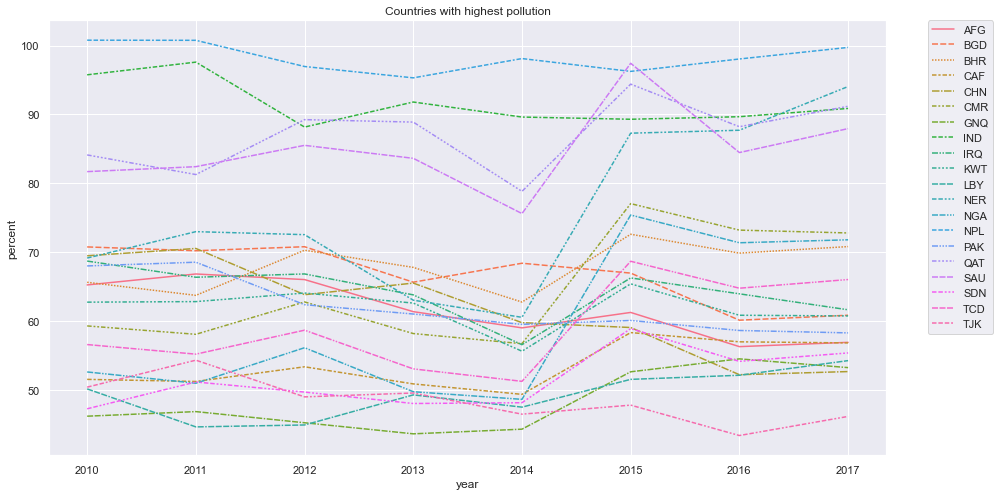

In [68]:


query_a = '''
SELECT year, percent, iso_code
FROM air_polution_pd_cleaned_transposed
WHERE  iso_code IN(
  SELECT DISTINCT iso_code 
  FROM air_polution_pd_cleaned_transposed 
  ORDER BY percent DESC
  LIMIT 20
)
ORDER BY year ASC, iso_code, percent
'''

graph_query0 = psql.sqldf(query_a)
linePlot(graph_query0)
plt.title('Countries with highest pollution')

Text(0.5, 1.0, 'Countries with lowest pollution')

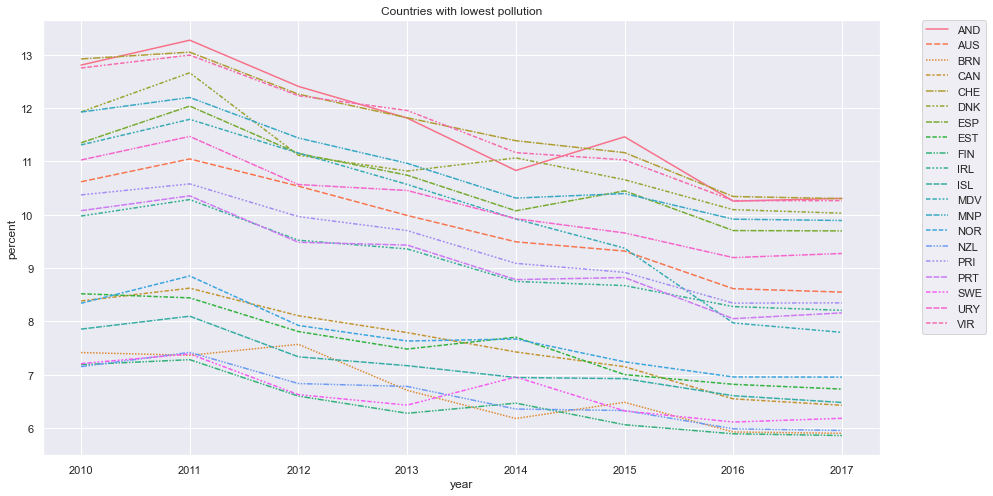

In [69]:

query_b = '''
SELECT year, percent, iso_code
FROM air_polution_pd_cleaned_transposed
WHERE  iso_code IN(
  SELECT DISTINCT iso_code 
  FROM air_polution_pd_cleaned_transposed 
  ORDER BY percent 
  LIMIT 20
)
ORDER BY year ASC, iso_code, percent
'''

graph_query0 = psql.sqldf(query_b)
linePlot(graph_query0)
plt.title('Countries with lowest pollution')

Worst polluters at the city level

In [70]:
def cityLevelBarPlot(data_input):
  sns.set_theme(style="whitegrid")
  sns.set(rc = {'figure.figsize':(25,8)})
  sns.barplot(x ="City", y = "pollution", data=data_input )

In [71]:
query1 = '''
SELECT  City, max(pm25) as pollution
FROM weather_with_pop
WHERE Date LIKE '2021-01%'
GROUP BY City
ORDER BY pm25 DESC
LIMIT 20
'''

query2 = '''
SELECT City, max(pm25) as pollution
FROM weather_with_pop
WHERE Date LIKE '2021-11%'
GROUP BY City
ORDER BY pm25 DESC
LIMIT 20
'''


graph_query1 = psql.sqldf(query1)
graph_query2 = psql.sqldf(query2)


In [72]:
query3 = '''
SELECT City, max(pm25) as pollution, short_date as date
FROM weather_with_pop
WHERE City IN (
  SELECT City
  FROM weather_with_pop
  WHERE Date LIKE '2021-06%' 
  GROUP BY City
  ORDER BY pm25 DESC
  LIMIT 10
)
GROUP BY City, short_date
ORDER BY short_date, pm25 DESC 
'''

graph_query3 = psql.sqldf(query3)

In [73]:
print(graph_query3.shape[0])

293


In [74]:
graph_query1

,City,pollution
0,Aguascalientes,825.0
1,Delhi,431.0
2,Bishkek,429.0
3,Lahore,390.0
4,Peshawar,378.0
5,Hohhot,357.0
6,Kathmandu,346.0
7,Xuchang,341.0
8,Dushanbe,335.0
9,Dhaka,332.0


Text(0.5, 1.0, 'Top pollution cities in the summer (Jun)')

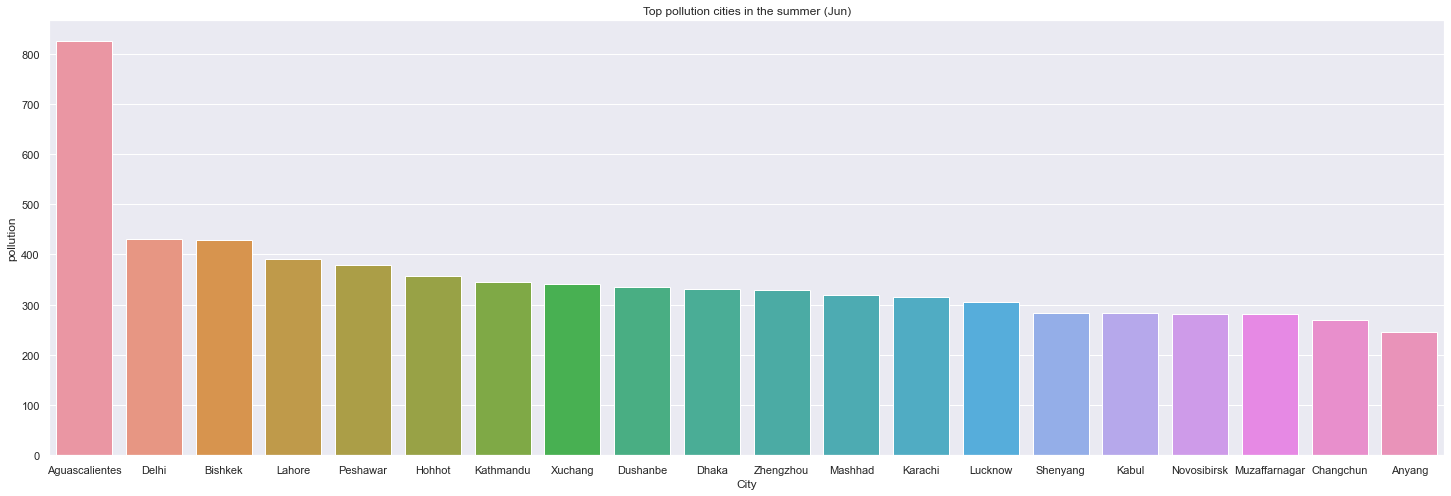

In [75]:
cityLevelBarPlot(graph_query1)
plt.title('Top pollution cities in the summer (Jun)')

Text(0.5, 1.0, 'Top pollution cities in the winter (Nov)')

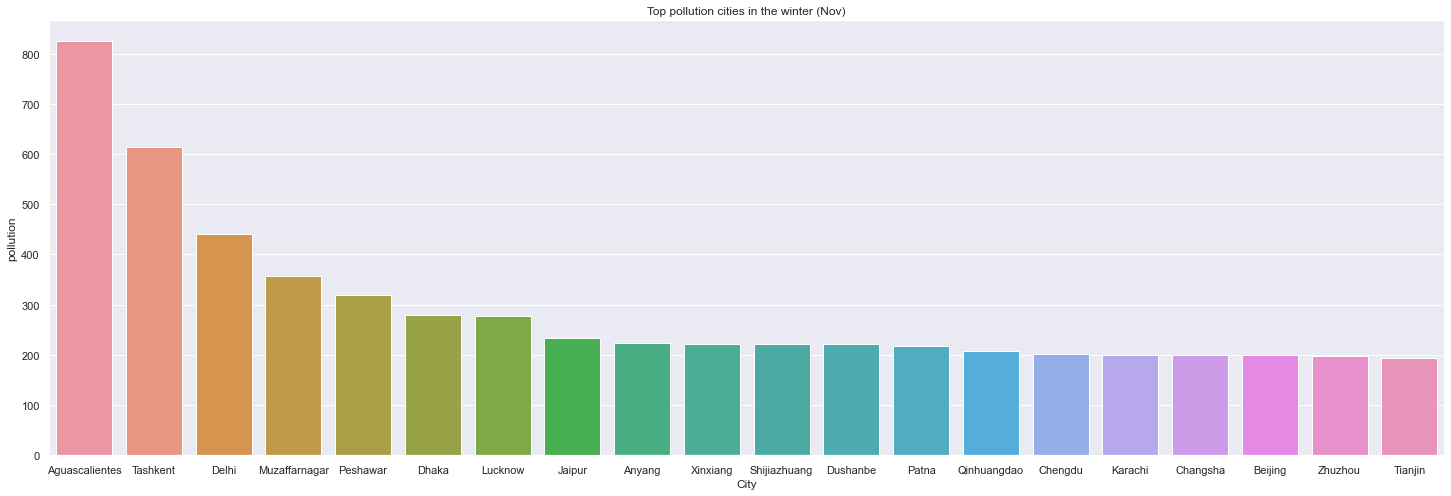

In [76]:
cityLevelBarPlot(graph_query2)
plt.title('Top pollution cities in the winter (Nov)')

Generally, we are seeing that there is a rise in pm 2.5 in the winter seasons between November to Feburary 

<AxesSubplot:xlabel='date', ylabel='pollution'>

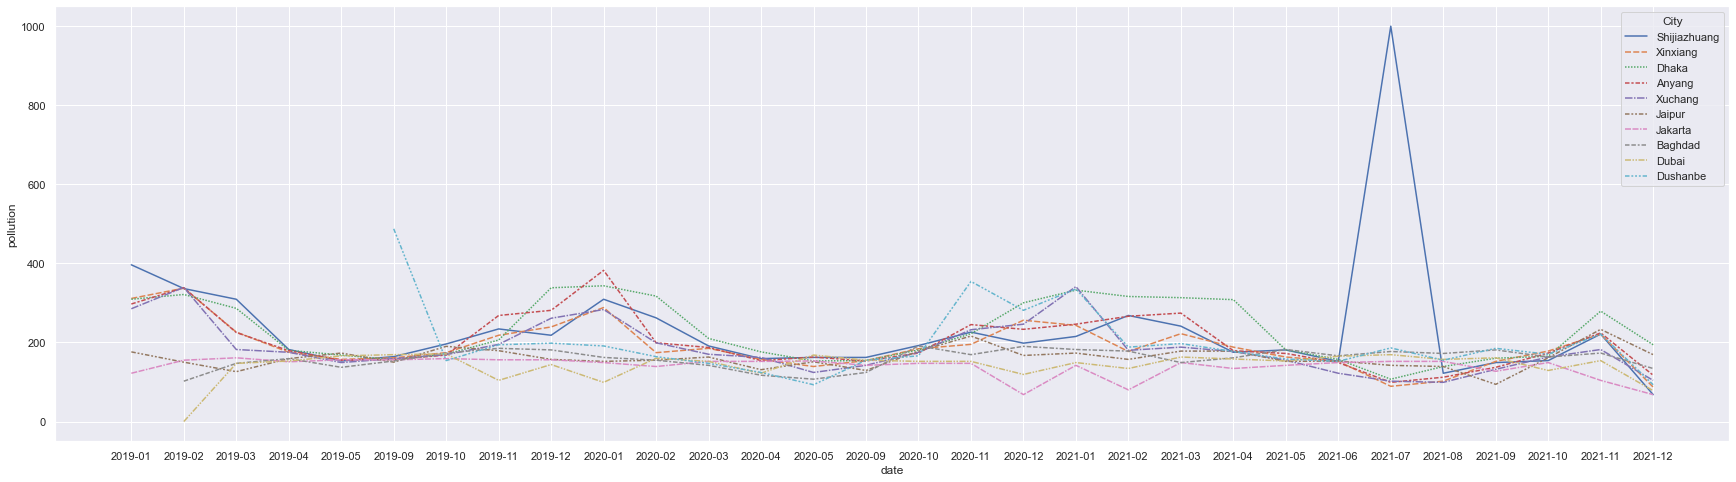

In [77]:
sns.set(rc = {'figure.figsize':(30,8)})
sns.lineplot(data=graph_query3, x="date", y="pollution", hue="City", style="City")

training time 
accuracy 
notablity of the approach 


Graph relationship between pollution and tempature 

In [78]:
query = '''
SELECT AVG(temperature) as temperature , AVG(pm25) as pm25, short_date
FROM vaild_values_pollution
GROUP BY short_date 
'''
temp_and_pm25 = psql.sqldf(query)


Observations


*   The winter month when the tempature are lower, there is a higher rate of pollution. The immediate relationship between the pollution and tempature is inverse relationship
*   The is a gradual decrease in pollutions 
*   There is a gradual increase in highest and lowest tempature 



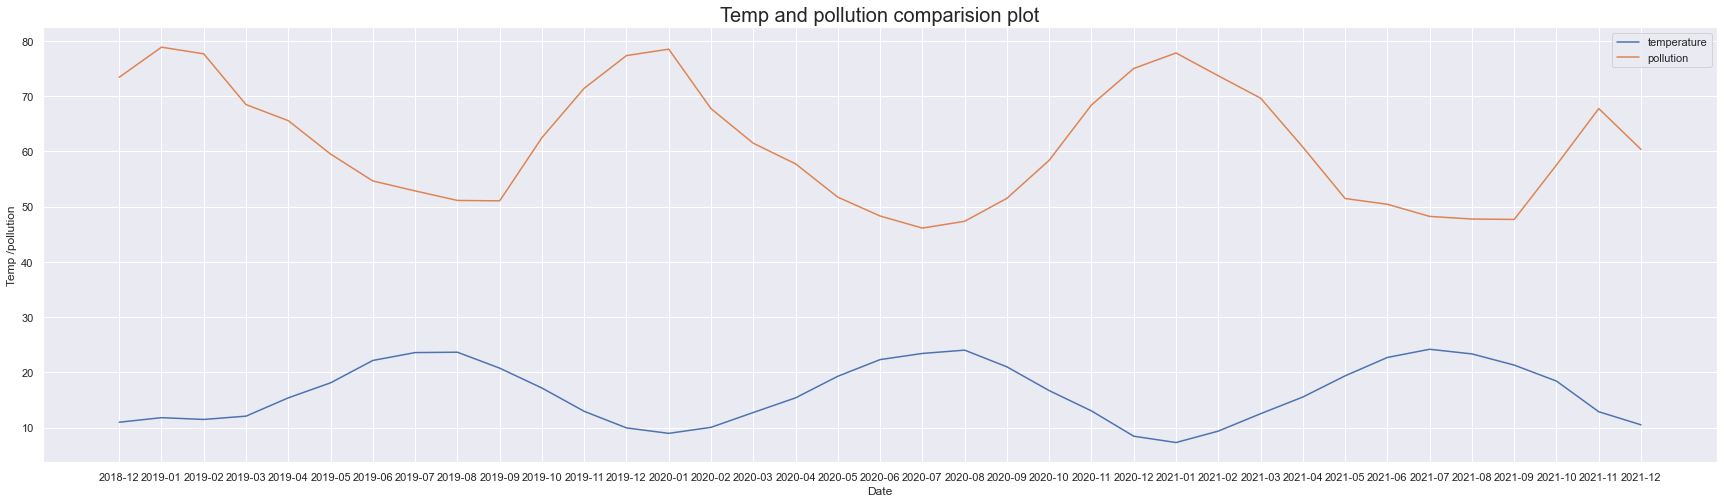

In [79]:
import matplotlib.pyplot as plt
Date =  temp_and_pm25['short_date']
temp = temp_and_pm25['temperature']
pm25 = temp_and_pm25['pm25']

plt.plot(Date, temp, label = "temperature" )
plt.plot(Date, pm25, label = "pollution" )
plt.legend()

plt.title("Temp and pollution comparision plot", fontsize = 20) # for title
plt.xlabel("Date", fontsize = 12) # label for x-axis
plt.ylabel("Temp /pollution", fontsize = 12) # label for y-axis
plt.show()

# 3 Creating Model

#### **3.1.** Correlation of Feature Variables

There will be two sets of each steps because the same process was ran acorss one dataset with population and one with out population information. Both datasets have about 250k records. The dataset without population information also had none deterministic values like 0.0 dropped from the dataset.

<AxesSubplot:>

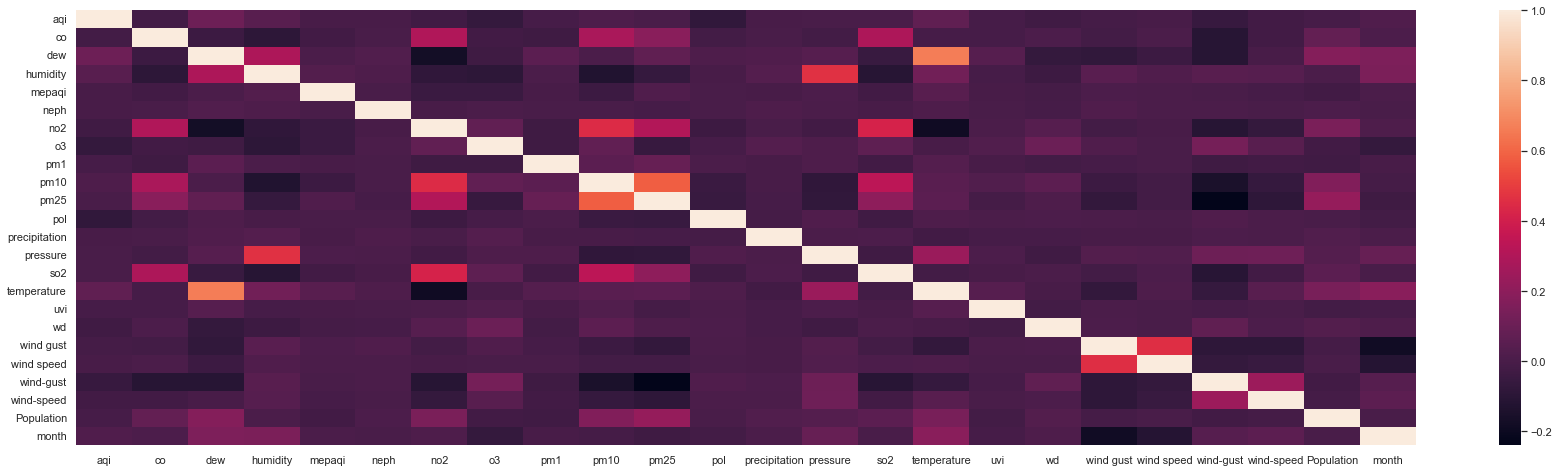

In [80]:
weather_with_pop_corr = weather_with_pop.corr()
sns.heatmap(data = weather_with_pop_corr, annot=False)

dew, pressure, no2, population, wind-gust, uvi, so2, wind-speed, pm25

In [81]:
vaild_values_pollution = vaild_values_pollution.drop(columns = ['mepaqi'])

<AxesSubplot:>

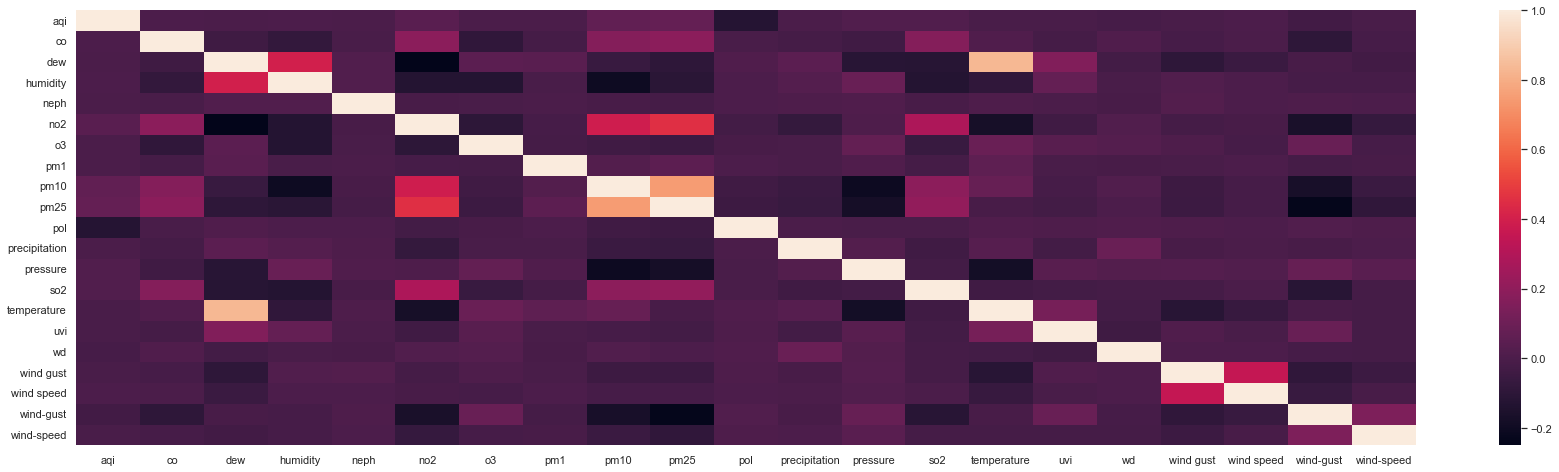

In [82]:
weather_corr = vaild_values_pollution.corr()
sns.heatmap(data = weather_corr, annot=False)

#### **3.2** Select the key columns

In [229]:
new_weather_df = weather_with_pop[['dew', 'pressure', 'no2', 'Population', 'wind-gust', 'so2', 'wind-speed', 'pm25', 'pm10','month', 'humidity', 'co','datetime','short_date','City','Country', 'temperature']]


In [110]:
new_weather_df2 = vaild_values_pollution[['dew', 'pressure', 'no2', 'wind-gust', 'so2', 'pm25', 'pm10', 'temperature','City','Country','month', 'humidity', 'short_date','co','datetime']]

#### **3.2** Encode Categorical Variables using LabelEncoder

In [111]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

el = LabelEncoder()
city_labels = el.fit_transform(new_weather_df['City'])
country_labels = el.fit_transform(new_weather_df['Country'])
short_date_labels = el.fit_transform(new_weather_df['short_date'])

city_labels2 = el.fit_transform(new_weather_df2['City'])
country_labels2 = el.fit_transform(new_weather_df2['Country'])
short_date_labels2 = el.fit_transform(new_weather_df2['short_date'])


In [112]:
pd.options.mode.chained_assignment = None  # default='warn'

In [113]:
new_weather_df['city_labels'] = city_labels
new_weather_df['country_labels'] = country_labels
new_weather_df['short_date_labels'] = short_date_labels


new_weather_df2['city_labels'] = city_labels2
new_weather_df2['country_labels'] = country_labels2
new_weather_df2['short_date_labels'] = short_date_labels2

<AxesSubplot:>

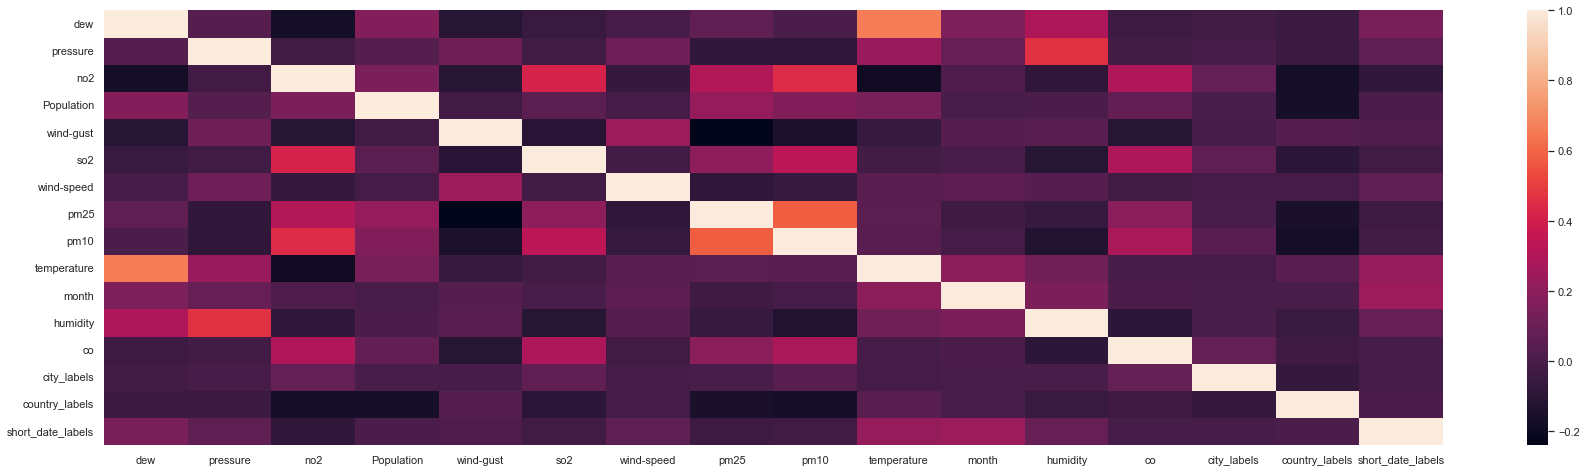

In [114]:
# updated correlation heatmap based on feature variables
updated_weather_df_corr = new_weather_df.corr()

#  heatmap for easier visualization
sns.heatmap(data = updated_weather_df_corr, annot=False)


<AxesSubplot:>

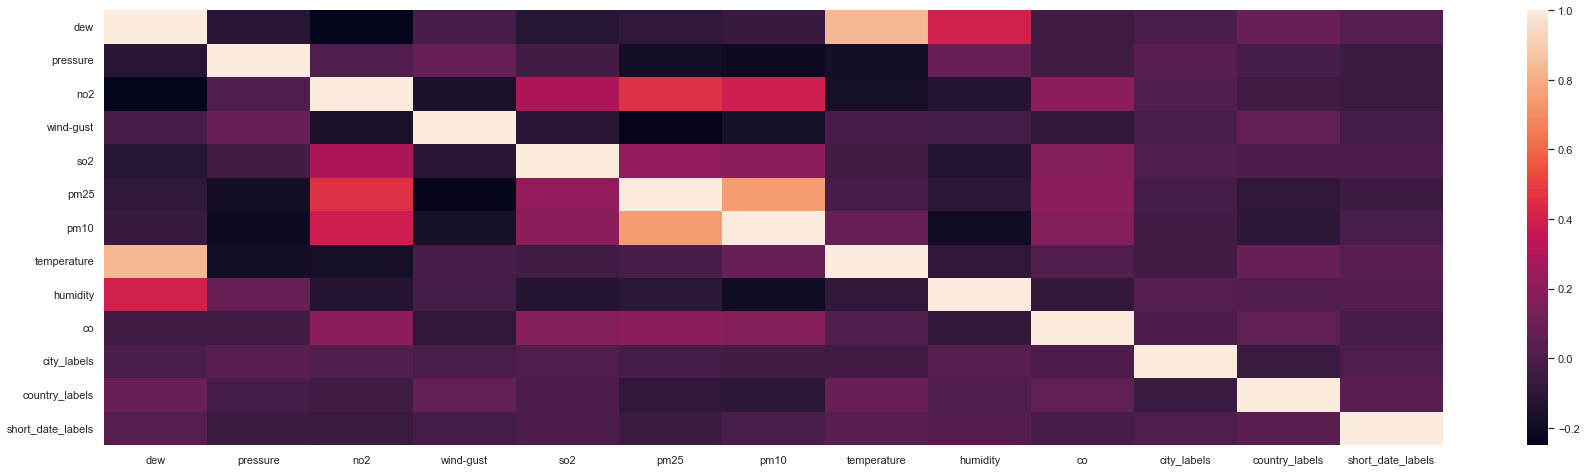

In [100]:
updated_weather_df2_cor = new_weather_df2.corr()
sns.heatmap(data = updated_weather_df2_cor, annot=False)

#### **3.4** Split into train and test

Change all data type to int for using Naive Bayes classification

In [121]:
    new_weather_df["date_idx"] = pd.to_datetime(new_weather_df.datetime)
    new_weather_df = new_weather_df.set_index("date_idx")
    new_weather_df.index = new_weather_df.index.to_period("M")

### **3.5** Modelling

#### **3.5.1** Split Data into Train and Test

In [155]:
# split by years 
#Training 2019  
#Validation 2020 
#Testing 2021


x_train =  new_weather_df[(new_weather_df['datetime']> '2018-12') & (new_weather_df['datetime']<= '2019-12')]

x_valid = new_weather_df[(new_weather_df['datetime']> '2019-12') & (new_weather_df['datetime']<= '2020-12')]

x_test = new_weather_df[(new_weather_df['datetime']> '2020-12') & (new_weather_df['datetime']<= '2021-12')]

y_train = x_train['temperature']
y_test = x_test['temperature']

x_train = x_train[['dew', 'pressure', 'no2', 'Population', 'wind-gust', 'so2', 'wind-speed', 'pm25', 'pm10','month', 'humidity',  'co','city_labels','country_labels','short_date_labels']]
x_valid = x_valid[['dew', 'pressure', 'no2', 'Population', 'wind-gust', 'so2', 'wind-speed', 'pm25', 'pm10','month', 'humidity', 'co','city_labels','country_labels','short_date_labels']]
x_test = x_test[['dew', 'pressure', 'no2', 'Population', 'wind-gust', 'so2', 'wind-speed', 'pm25', 'pm10','month', 'humidity', 'co','city_labels','country_labels','short_date_labels']]


In [258]:
# split by years 
#Training 2019  
#Validation 2020 
#Testing 2021


x_train2 =  new_weather_df2[(new_weather_df2['datetime']> '2018-12') & (new_weather_df2['datetime']<= '2019-12')]

x_valid2 = new_weather_df2[(new_weather_df2['datetime']> '2019-12') & (new_weather_df2['datetime']<= '2020-12')]

x_test2 = new_weather_df2[(new_weather_df2['datetime']> '2020-12') & (new_weather_df2['datetime']<= '2021-12')]

y_train2 = x_train2['temperature']
y_test2 = x_test2['temperature']

x_train2 = x_train2[['dew', 'pressure', 'no2', 'wind-gust', 'so2', 'pm25', 'pm10','month', 'humidity',  'co','city_labels','country_labels','short_date_labels']]
x_valid2 = x_valid2[['dew', 'pressure', 'no2', 'wind-gust', 'so2',  'pm25', 'pm10','month', 'humidity', 'co','city_labels','country_labels','short_date_labels']]
x_test2 = x_test2[['dew', 'pressure', 'no2',  'wind-gust', 'so2',  'pm25', 'pm10','month', 'humidity', 'co','city_labels','country_labels','short_date_labels']]


In [156]:
x_train = x_train.astype('int64')
x_valid = x_valid.astype('int64')
x_test = x_test.astype('int64')
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [262]:
x_train2 = x_train2.astype('int64')
x_valid2 = x_valid2.astype('int64')
x_test2 = x_test2.astype('int64')
y_train2 = y_train2.astype('int64')
y_test2 = y_test2.astype('int64')

#### **3.5.2**  SVM Regression model

In [250]:
from sklearn import svm

X = x_train
y = y_train
regr = svm.SVR()
regr.fit(X, y)

y_pred = regr.predict(x_test)

array([19.93336656, 20.13956894, -2.28476412, ..., 10.77503609,
        8.53743328,  9.08012234])

In [255]:
score = regr.score(x_train, y_train)
print("R-squared:", score) 

R-squared: 0.783629297190152


In [253]:
#from sklearn import metrics
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

MSE:  75.36920461391072
RMSE:  37.68460230695536


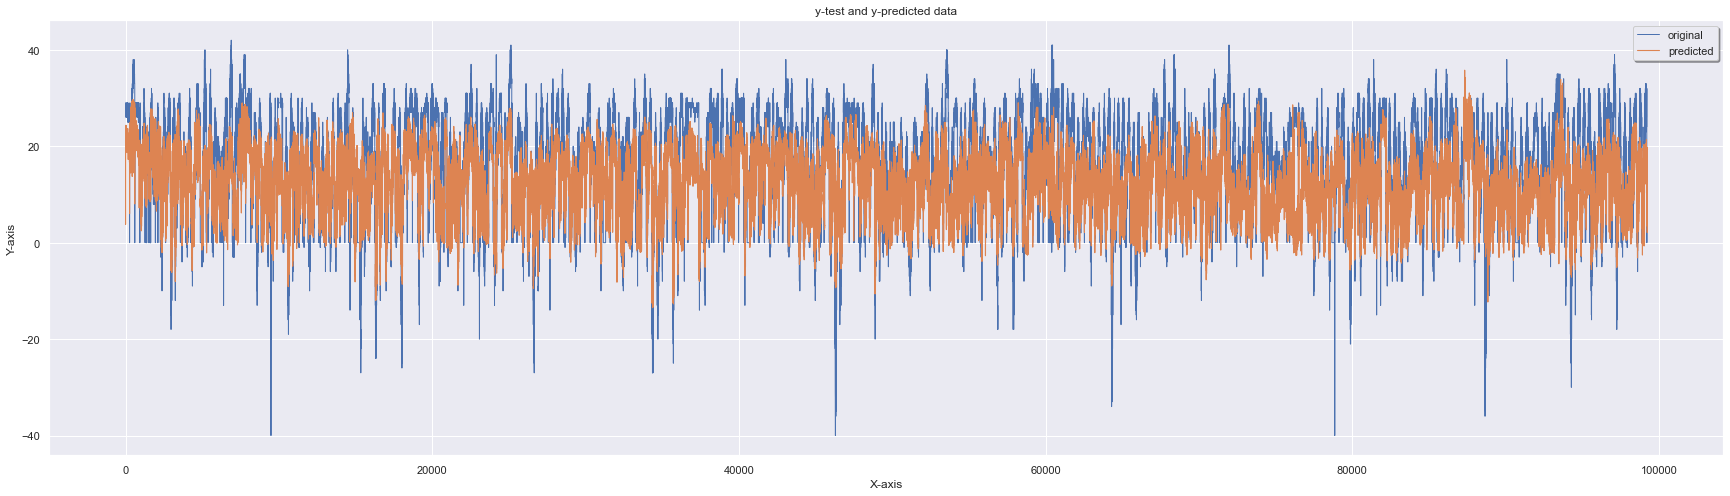

In [256]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [263]:
X2 = x_train2
y2 = y_train2
regr2 = svm.SVR()
regr2.fit(X2, y2)



SVR()

In [265]:
y_pred2 = regr2.predict(x_test2)

In [267]:

score2 = regr2.score(x_train2, y_train2)
print("R-squared:", score2) 


R-squared: 0.7427320309402713


In [268]:
mse2 = mean_squared_error(y_test2, y_pred2)
print("MSE: ", mse2)
print("RMSE: ", mse2*(1/2.0)) 

MSE:  18.8849210724414
RMSE:  9.4424605362207


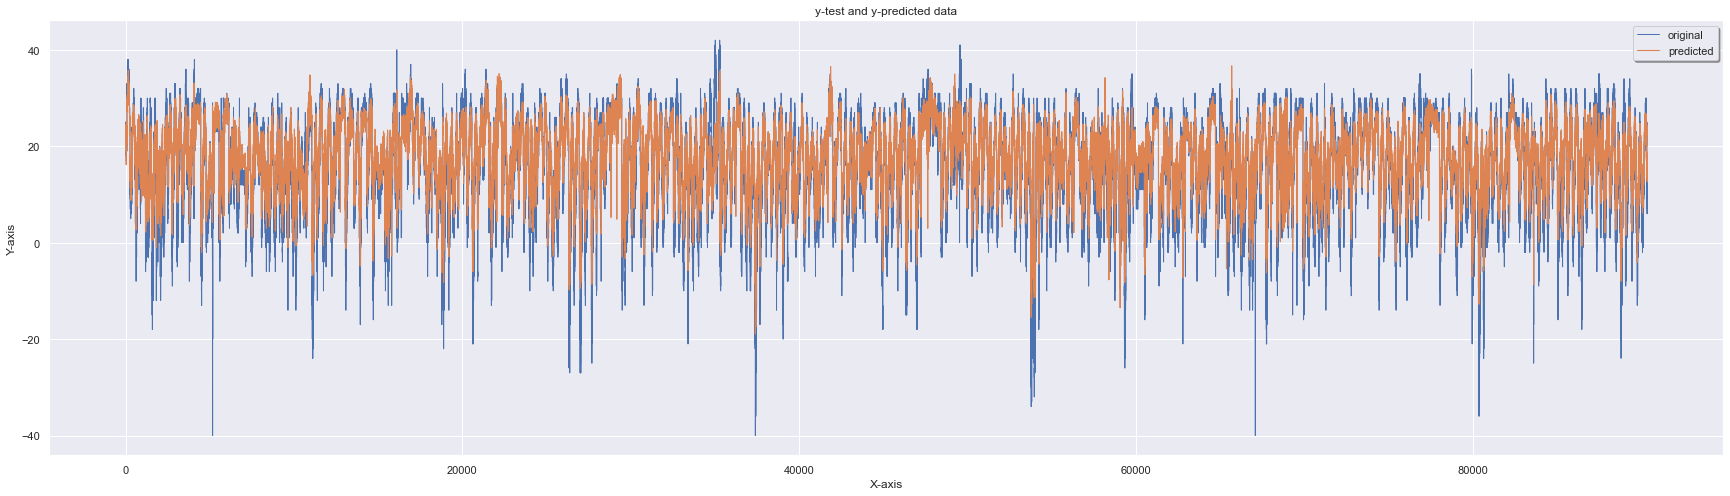

In [269]:
x_ax = range(len(y_test2))
plt.plot(x_ax, y_test2, linewidth=1, label="original")
plt.plot(x_ax, y_pred2, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

#### **3.5.3** Dimensionality Reduction with PCA

In [160]:
#nb2 = GaussianNB()
#nb2.fit(x_train2, y_train2)
#y_pred2 = nb2.predict(x_test2)
#y_pred2

(66007, 15)
[[ 1.08641194e-02 -1.22520996e-01  4.03976512e-01  1.99049355e-01
  -2.53146470e-01  3.62160621e-01 -2.24325360e-01  4.32821069e-01
   4.71287289e-01 -1.08970221e-01 -1.29349200e-01  2.17337114e-01
   5.69112668e-02 -1.86262566e-01 -1.15186899e-01]
 [ 3.18632549e-01  1.91668001e-01  3.87719059e-02  1.08819070e-01
  -1.19925300e-01  6.11309288e-02  2.77500992e-03  8.80696826e-02
   6.95836364e-02  6.00632129e-01  3.02216601e-01  7.17259181e-02
   8.76542156e-03 -8.98348345e-02  5.93532930e-01]
 [-1.41588612e-01  3.95536319e-01  1.85726107e-01  1.68604630e-01
   4.21965449e-01  1.24350349e-01  5.30992492e-01  2.81993703e-03
   7.44697321e-02 -1.16200531e-01  2.64894391e-01  5.24305913e-02
   1.17971093e-01 -4.05764737e-01 -1.20725468e-01]
 [-3.43372663e-01 -3.03465516e-01  2.08340085e-01 -2.21255630e-01
   3.13336571e-01  2.96272196e-01  2.52301491e-01 -1.85879368e-01
   7.25309630e-02  2.78537441e-01 -4.10264432e-01  2.08530574e-01
   2.16357094e-02  1.85727525e-01  2.896057

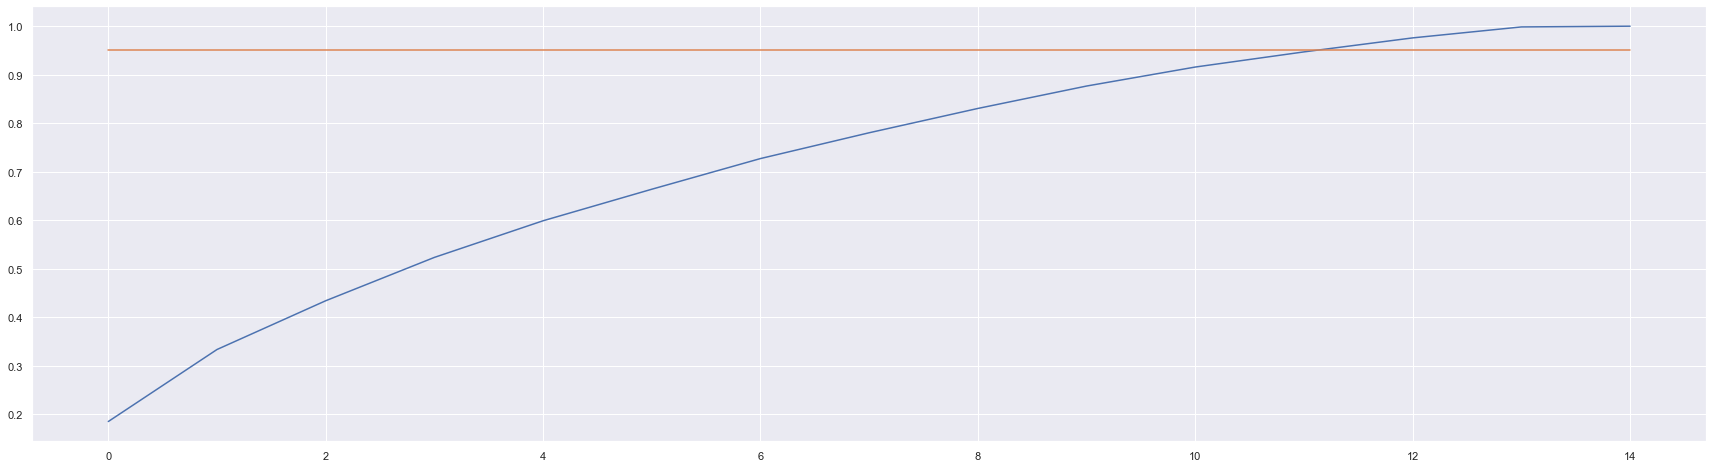

In [163]:
# TO DO PCA
# scaling
# find num components to use
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

pca = PCA(n_components = 15)
pca_x_train = pca.fit_transform(scaled_x_train)


print(pca_x_train.shape)

print(pca.components_)
# TO DO plot for explained variance
pca.explained_variance_ratio_
plt.plot(np.arange(0, 15), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 15), [0.95]*15)
plt.show()

(66007, 15)
[[-2.10058081e-01 -6.22002531e-02  4.04987087e-01 -2.05004949e-01
   2.55229408e-01  4.94112014e-01  4.73754009e-01 -2.29931242e-01
  -2.78067995e-01  1.09955709e-01  9.52390913e-03 -1.29194086e-01
  -2.30589042e-01]
 [ 2.29434296e-01 -2.03979784e-01  1.42899025e-01 -2.14656227e-01
   1.43662944e-01  1.86582774e-01  1.98384139e-01  6.03504908e-01
   4.84479714e-02  9.41597150e-02  1.86342605e-02  6.41227330e-02
   6.03784641e-01]
 [-5.89054169e-01  1.00265194e-01  1.32784304e-01  3.04204642e-01
   1.77699856e-01 -2.41768776e-01 -1.59860053e-01  2.20227525e-01
  -5.47097895e-01  6.37018211e-02 -1.54738057e-02  1.29226555e-01
   2.19982254e-01]
 [ 1.72318944e-01  2.07068036e-01  1.30808104e-01  2.23859558e-02
   2.45066946e-01 -3.23208701e-02 -9.20361756e-02 -1.06977199e-01
   1.52283742e-01  6.42506580e-01 -1.54274590e-02  6.17307980e-01
  -1.07180696e-01]
 [-1.04801621e-01  5.67663077e-01  2.38145731e-01 -2.31600257e-01
   1.87396182e-01 -9.36694142e-02 -1.77699354e-01  6.7

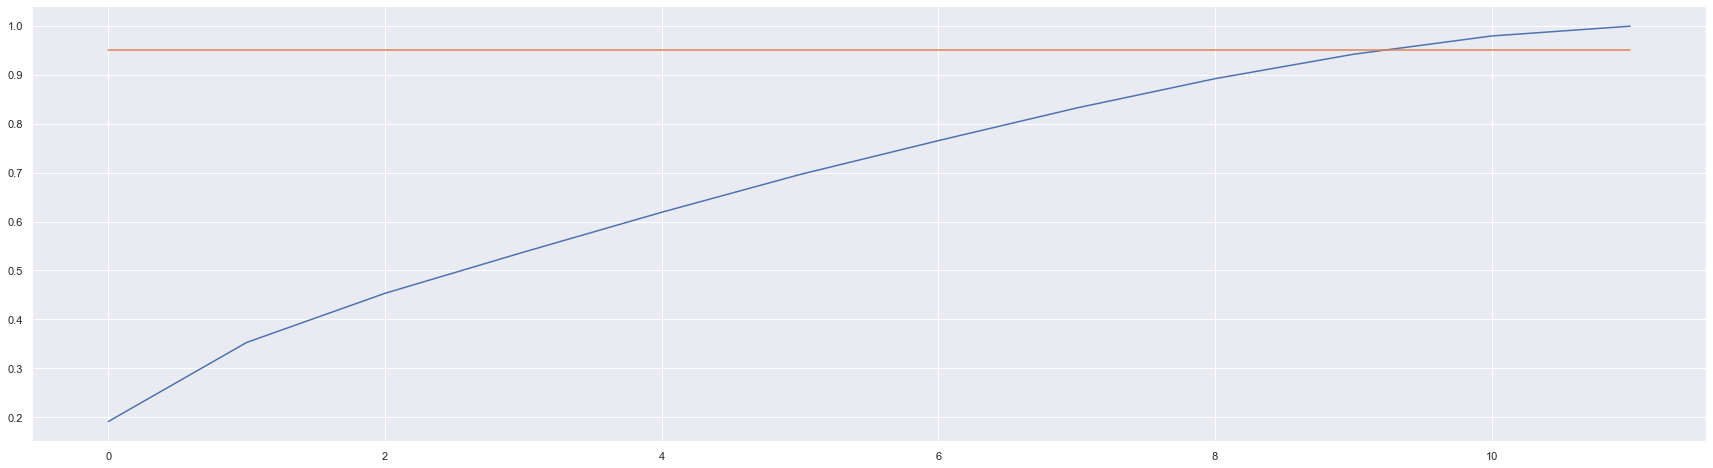

In [270]:
scaler2 = StandardScaler()
scaled_x_train2 = scaler.fit_transform(x_train2)
scaled_x_test2 = scaler.transform(x_test2)

pca = PCA(n_components = 12)
pca_x_train2 = pca.fit_transform(scaled_x_train2)


print(pca_x_train.shape)

print(pca.components_)
# TO DO plot for explained variance
pca.explained_variance_ratio_
plt.plot(np.arange(0, 12), np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(0, 12), [0.95]*12)
plt.show()

In [167]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.18548718 0.14838717 0.10045647 0.08931707 0.07548483 0.064965
 0.06319613 0.0531511  0.05008791 0.04616458 0.03914842 0.03120223
 0.0288564  0.02257757 0.00151793]


In [168]:
pca = PCA(n_components=12 ) # TODO update this number
x_train_pca = pca.fit_transform(scaled_x_train)
x_test_pca  = pca.transform(scaled_x_test)
x_train = x_train_pca
x_test = x_test_pca

In [271]:
pca = PCA(n_components=11 ) # TODO update this number
x_train_pca2 = pca.fit_transform(scaled_x_train2)
x_test_pca2  = pca.transform(scaled_x_test2)
x_train2 = x_train_pca2
x_test2 = x_test_pca2

Reducing the PCA to 2 and plotting the result to see the outcome 

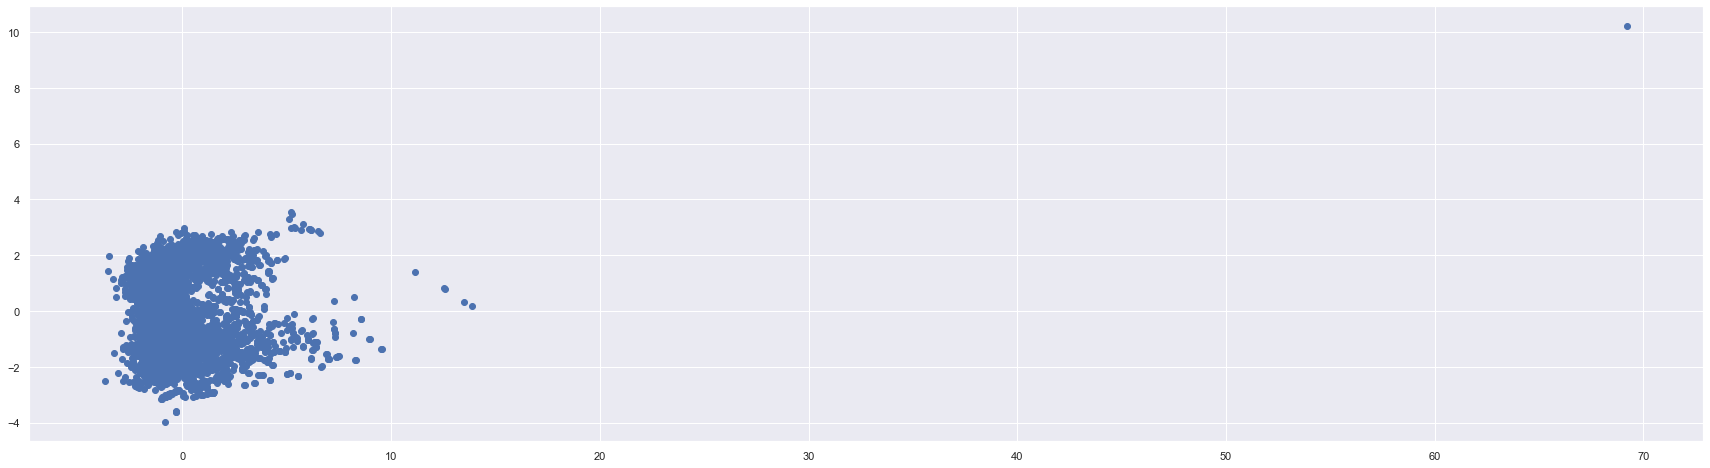

In [169]:
# visualize 2 components of PCA
pca_plot = PCA(n_components=2)
comp = pca_plot.fit_transform(x_train_pca)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

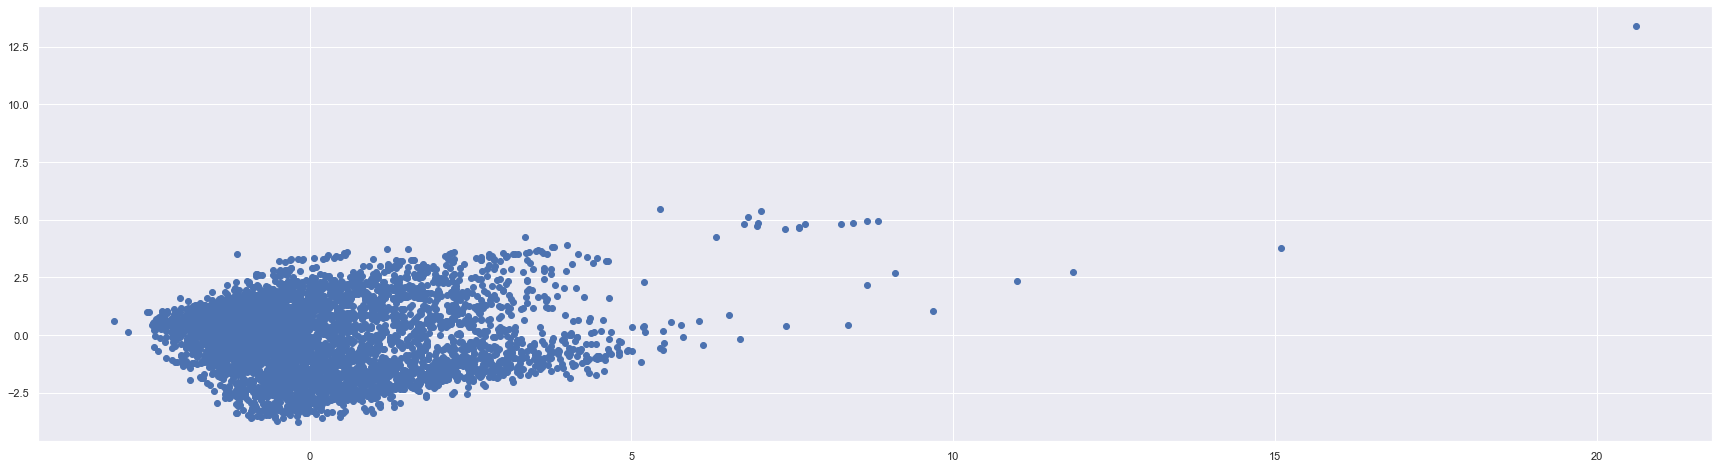

In [272]:
# visualize 2 components of PCA
pca_plot = PCA(n_components=2)
comp = pca_plot.fit_transform(x_train_pca2)
data = np.transpose(np.array(comp))
plt.scatter(data[0][0:5000], data[1][0:5000])

#### 3.5.4 Regressor Random Forest

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error

#from sklearn.grid_search import GridSearchCV


In [243]:
#use this 



#x = scale(x)
#y = scale(y)
#regr = RandomForestRegressor(max_depth=2, random_state=0, n_jobs =2, verbose =1)
rr = RandomForestRegressor(n_jobs =2, verbose =1)
rr.fit(x_train_pca, y_train)

print(rr.predict([[0, 0, 0, 0,0,0,0,0,0,0,0,0]]))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.7s


[16.25]


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   44.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [244]:

score = rr.score(x_train_pca, y_train)
print("R-squared:", score) 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s


R-squared: 0.983506484303746


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished


In [245]:

y_pred = rr.predict(x_test_pca)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s


MSE:  75.36920461391072
RMSE:  37.68460230695536


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.6s finished


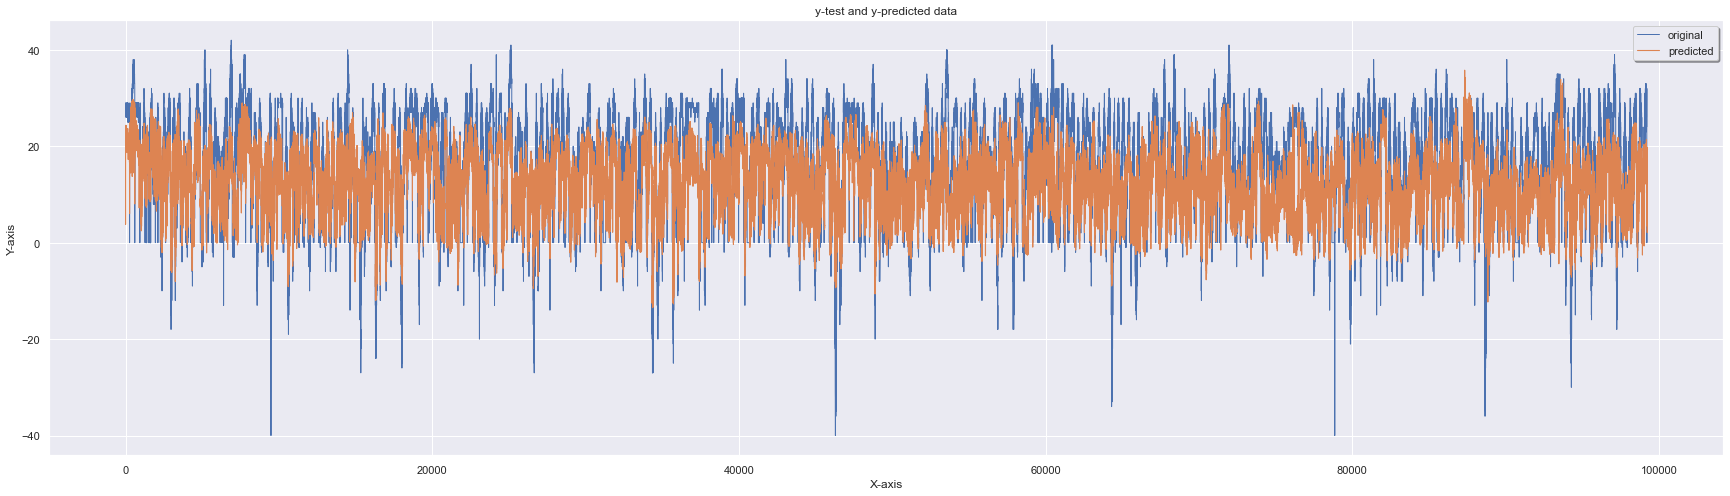

In [246]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [273]:
rr2 = RandomForestRegressor(n_jobs =2, verbose =1)
rr2.fit(x_train_pca2, y_train2)

print(rr.predict([[0, 0, 0, 0,0,0,0,0,0,0,0,0]]))

score2 = rr2.score(x_train_pca2, y_train2)
print("R-squared:", score2) 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   24.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   48.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


[16.25]


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s


R-squared: 0.9833841954935018


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished


In [274]:

y_pred2 = rr2.predict(x_test_pca2)

mse2 = mean_squared_error(y_test2, y_pred2)
print("MSE: ", mse2)
print("RMSE: ", mse2*(1/2.0)) 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s


MSE:  48.59440609853263
RMSE:  24.297203049266315


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


## 3.6 Modeling with Timeseries approach (Arima and Sarima 

### 3.6.0 Arima time series model 

In [151]:
%%capture
!pip install pandas
!pip install plotly-express
!pip install statsmodels
!pip install tqdm

In [200]:
 
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels as sm 
from sklearn.metrics import r2_score
from tqdm import tqdm
import plotly.express as px
from sklearn.preprocessing import StandardScaler
# model imports
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm1
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import math
from sklearn.decomposition import PCA
import pickle


In [213]:
def get_city_df(city):
    df = new_weather_df
    df = df[df["City"] == city]
    df["date_idx"] = pd.to_datetime(df.datetime)
    df = df.set_index("date_idx")
    df.index = df.index.to_period("M")
    return df

def get_test_train_valid(city):
    city_df = get_city_df(city)


    train = city_df[(city_df['datetime']> '2018-12') & (city_df['datetime']<= '2019-12')]
    valid = city_df[(city_df['datetime']> '2019-12') & (city_df['datetime']<= '2020-12')]
    test  = city_df[(city_df['datetime']> '2020-12') & (city_df['datetime']<= '2021-12')]
    
    return train, test, valid

def scale(train_x, valid_x, test_x):
    scaler = StandardScaler()
    model_x = pd.concat([train_x, valid_x])

    scaler.fit(model_x)
    model_x = scaler.transform(model_x)
    train_x = scaler.transform(train_x)
    valid_x = scaler.transform(valid_x)
    test_x  = scaler.transform(test_x)
    
    return train_x, valid_x, test_x, model_x

def pca_fitter(train_x, threshold = .99):
    n_features = train_x.shape[1]
    
    for n in range(1, n_features + 1):
        pca_model = PCA(n)
        pca_model.fit(train_x)
        
        if sum(pca_model.explained_variance_ratio_) >= threshold:
            break
    return pca_model


### 3.6.1 Scaling Data By Standard Scalar

### 3.6.2 Hypertuning Model Parameters With Training and Validation Set

In [206]:
def eval_arima_excog_walk_forward_validation_model(train_x, train_y, test_x, test_y, arima_order):
    # DO NOT USE THIS 

    history = [x for x in train_y]
    predictions = []
    
    for i in range(len(test_x)):
        model = ARIMA(history, exog = train_x, order = arima_order)
        model_fit = model.fit()
        
        y_hat = model_fit.forecast(exog = test_x.iloc[[i]])
        predictions.append(y_hat[0])
        
        train_x = pd.concat([train_x, test_x.iloc[[i]]], axis = 0)
        history.append(test_y[i])

    rmse = math.sqrt(mean_squared_error(test_y, predictions))
    return model_fit, rmse, predictions

def eval_arima_excog(train_x, train_y, test_x, test_y, arima_order, trend = 'c'):
    # DO NOT USE THIS 
    model = ARIMA(train_y, exog = train_x, order = arima_order, trend = trend)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test_x), exog = test_x)
    rmse = math.sqrt(mean_squared_error(test_y, predictions))
    return model_fit, rmse, predictions

def eval_sarimax_excog(train_x, train_y, test_x, test_y, arima_order):
    # USE THIS
    model = sm1.tsa.statespace.SARIMAX(train_y, exog = train_x, order = arima_order, \
                                       time_varying_regression = True, mle_regression = False, measurement_error = True)
    model_fit = model.fit(disp = 0)
    predictions = model_fit.forecast(len(test_x), exog = test_x)
    rmse = math.sqrt(mean_squared_error(test_y, predictions))
    predictions.index = test_y.index
    return model_fit, rmse, predictions

def eval_excog_models(train_x, train_y, test_x, test_y, p_values, d_values, q_values, f):
    arima_orders = itertools.product(*[p_values, d_values, q_values])
    arima_orders = list(arima_orders)
    best_order, best_score = None, float("inf") 
    
    count = 0
    for arima_order in tqdm(arima_orders):
        try:
            _, rmse, _ = f(train_x, train_y, test_x, test_y, arima_order)
            
            if rmse < best_score:
                best_score, best_order = rmse, arima_order
                print(f"ARIMA RMSE = {best_score}")
        except Exception as e:
            print(e)
            pass
        count += 1
    print('DONE')
    return best_order

In [233]:
def ml(city, p_values = [0, 1, 2, 3], d_values = range(0, 3), q_values = range(0, 3)):
    train, test, valid = get_test_train_valid(city)

    train_x, train_y = train[train.columns[0:-5]], train["temperature"]
    test_x, test_y = test[test.columns[0:-5]], test["temperature"]
    valid_x, valid_y = valid[valid.columns[0:-5]], valid["temperature"]

    train_x, valid_x, test_x, model_x = scale(train_x, valid_x, test_x)

    pca_model = pca_fitter(train_x)
    train_x = pca_model.transform(train_x)
    valid_x = pca_model.transform(valid_x) 
    test_x  = pca_model.transform(test_x)
    model_x = pca_model.transform(model_x)
    
    model_y = pd.concat([train_y, valid_y])

    best = eval_excog_models(train_x, train_y, valid_x, valid_y, p_values, d_values, q_values, eval_sarimax_excog)

    model_fit, rmse, predictions = eval_sarimax_excog(model_x, model_y, test_x, test_y, best)
    
    return best, test_y, predictions

In [234]:
def plot(df, city, layout, line1 = 'temperature', line2 = 'Predictions', x = 'year', error = 'TempUncertainty'):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go


    fig = go.Figure(layout = layout)
    trace_1 = go.Line(name = f"Actual {city} Avg Yearly Temp", 
                     x = test[x],
                     y = test[line1],
                     error_y = dict(type='data', array = test[error]))


    trace_2 = go.Line(name = f"Predictions of {city} Avg Yearly Temp", 
                     x = test[x],
                     y = test[line2])

    fig.add_trace(trace_1)
    fig.add_trace(trace_2)
    
    return fig

In [235]:
results = {"Aguascalientes": None, "Delhi": None, 
           "Bishkek": None, "Lahore": None, 
           "Peshawar": None}

for k in results.keys():
    results[k] = ml(k)

  3%|█▏                                          | 1/36 [00:00<00:13,  2.62it/s]

ARIMA RMSE = 14.35029289516585


  8%|███▋                                        | 3/36 [00:02<00:33,  1.02s/it]

Invalid dimensions for design matrix: requires 11 columns, got 10


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 14%|██████                                      | 5/36 [00:05<00:36,  1.18s/it]

ARIMA RMSE = 8.006238966757852


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 17%|███████▎                                    | 6/36 [00:07<00:45,  1.51s/it]

Invalid dimensions for design matrix: requires 12 columns, got 10


 22%|█████████▊                                  | 8/36 [00:11<00:47,  1.68s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 25%|███████████                                 | 9/36 [00:16<01:05,  2.44s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 28%|███████████▉                               | 10/36 [00:19<01:05,  2.53s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/s

ARIMA RMSE = 7.968773746360269


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 42%|█████████████████▉                         | 15/36 [00:28<00:44,  2.12s/it]

ARIMA RMSE = 7.844746768742305


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 47%|████████████████████▎                      | 17/36 [00:34<00:47,  2.52s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 56%|███████████████████████▉                   | 20/36 [00:39<00:30,  1.93s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWar

DONE


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  3%|█▏                                          | 1/36 [00:00<00:15,  2.33it/s]

ARIMA RMSE = 17.770020454422202


  8%|███▋                                        | 3/36 [00:02<00:37,  1.13s/it]

ARIMA RMSE = 17.28406913361521
Invalid dimensions for design matrix: requires 9 columns, got 8


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 14%|██████                                      | 5/36 [00:04<00:28,  1.10it/s]

ARIMA RMSE = 7.411558699536782


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 17%|███████▎                                    | 6/36 [00:05<00:29,  1.03it/s]

ARIMA RMSE = 7.3893356797342715
Invalid dimensions for design matrix: requires 10 columns, got 8


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 22%|█████████▊                                  | 8/36 [00:06<00:21,  1.29it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 28%|███████████▉                               | 10/36 [00:09<00:29,  1.12s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 31%|█████████████▏                             | 11/36 [00:11<00:31,  1.27s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.

ARIMA RMSE = 7.347499123540601


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 47%|████████████████████▎                      | 17/36 [00:18<00:24,  1.27s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 50%|█████████████████████▌                     | 18/36 [00:19<00:25,  1.40s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 53%|██████████████████████▋                    | 19/36 [00:21<00:22,  1.29s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.

DONE


  3%|█▏                                          | 1/36 [00:00<00:10,  3.27it/s]

ARIMA RMSE = 26.008615108605944


  8%|███▋                                        | 3/36 [00:01<00:20,  1.57it/s]

ARIMA RMSE = 13.646486374167768
Invalid dimensions for design matrix: requires 8 columns, got 7


 14%|██████                                      | 5/36 [00:02<00:13,  2.31it/s]

ARIMA RMSE = 12.149667748858965


 17%|███████▎                                    | 6/36 [00:03<00:15,  1.89it/s]

ARIMA RMSE = 10.410328637695459
Invalid dimensions for design matrix: requires 9 columns, got 7


 22%|█████████▊                                  | 8/36 [00:03<00:13,  2.13it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 31%|█████████████▏                             | 11/36 [00:06<00:14,  1.68it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 33%|██████████████▎                            | 12/36 [00:06<00:15,  1.51i

ARIMA RMSE = 10.12430111047735


 36%|███████████████▌                           | 13/36 [00:07<00:13,  1.66it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 44%|███████████████████                        | 16/36 [00:09<00:11,  1.71it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 47%|████████████████████▎                      | 17/36 [00:10<00:14,  1.32it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 53%|██████████████████████▋                    | 19/36 [00:1

ARIMA RMSE = 10.087118030406048


 61%|██████████████████████████▎                | 22/36 [00:14<00:11,  1.26it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 67%|████████████████████████████▋              | 24/36 [00:16<00:10,  1.10it/s]

ARIMA RMSE = 9.358870395437371


 72%|███████████████████████████████            | 26/36 [00:18<00:08,  1.22it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 78%|█████████████████████████████████▍         | 28/36 [00:21<00:09,  1.21s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 81%|██████████████████████████████████▋        | 29/36 [00:22<00:07,  1.13s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/s

ARIMA RMSE = 9.346489984977453


 86%|█████████████████████████████████████      | 31/36 [00:24<00:05,  1.13s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 94%|████████████████████████████████████████▌  | 34/36 [00:27<00:02,  1.00s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 97%|█████████████████████████████████████████▊ | 35/36 [00:29<00:01,  1.35s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
100%|███████████████████████████████████████████| 36/36 [00:31<00:00,  1.14it/s]


DONE


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  3%|█▏                                          | 1/36 [00:00<00:05,  6.01it/s]

ARIMA RMSE = 208.89738266839663


  6%|██▍                                         | 2/36 [00:00<00:09,  3.50it/s]

ARIMA RMSE = 208.84368707768832


  8%|███▋                                        | 3/36 [00:00<00:09,  3.32it/s]

Invalid dimensions for design matrix: requires 7 columns, got 6


 14%|██████                                      | 5/36 [00:01<00:08,  3.87it/s]

ARIMA RMSE = 6.789877896583072


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 17%|███████▎                                    | 6/36 [00:02<00:12,  2.43it/s]

ARIMA RMSE = 6.669788387628526
Invalid dimensions for design matrix: requires 8 columns, got 6


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 25%|███████████                                 | 9/36 [00:03<00:11,  2.33it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 31%|█████████████▏                             | 11/36 [00:05<00:17,  1.40it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 36%|███████████████▌                           | 13/36 [00:06<00:14,  1.58it/s]

ARIMA RMSE = 6.5413140856224885


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 44%|███████████████████                        | 16/36 [00:08<00:13,  1.43it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 47%|████████████████████▎                      | 17/36 [00:09<00:13,  1.38it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 50%|█████████████████████▌                     | 18/36 [00:10<00:13,  1.30it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: Conv

DONE


  3%|█▏                                          | 1/36 [00:00<00:03,  9.98it/s]

ARIMA RMSE = 23.43112513671173


  8%|███▋                                        | 3/36 [00:00<00:09,  3.46it/s]

Invalid dimensions for design matrix: requires 6 columns, got 5


 14%|██████                                      | 5/36 [00:01<00:08,  3.57it/s]

ARIMA RMSE = 7.205150616525967


 17%|███████▎                                    | 6/36 [00:02<00:14,  2.05it/s]

Invalid dimensions for design matrix: requires 7 columns, got 5


 22%|█████████▊                                  | 8/36 [00:03<00:12,  2.29it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 28%|███████████▉                               | 10/36 [00:04<00:13,  1.97it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/st

ARIMA RMSE = 7.204592813318862


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 39%|████████████████▋                          | 14/36 [00:10<00:30,  1.38s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 42%|█████████████████▉                         | 15/36 [00:10<00:24,  1.17s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 47%|████████████████████▎                      | 17/36 [00:15<00:35,  1.87s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.

ARIMA RMSE = 7.046603920523649


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 64%|███████████████████████████▍               | 23/36 [00:20<00:11,  1.09it/s]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 75%|████████████████████████████████▎          | 27/36 [00:25<00:11,  1.23s/it]/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7

DONE


/Users/ashleyfchang/opt/anaconda3/envs/cis545/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [247]:
with open('Temperatue_Pollution_Time_Series.pickle', 'wb') as fh:
   pickle.dump(results, fh)

In [248]:
pickle_off = open ("Temperatue_Pollution_Time_Series.pickle", "rb")
results = pickle.load(pickle_off)

In [249]:
layout = dict(xaxis=dict(title='Date'),
              yaxis=dict(title='Temperature'))

for k, v in results.items():
    _, test, _ = get_test_train_valid(k)
    print("P, Q, D", v[0])
    test['Predictions'] = v[-1]
    fig = plot(test, k, layout)
    fig.show()

P, Q, D (1, 1, 2)


KeyError: 'year'